# CS2 Map Probability Regression

This notebook implements probabilistic prediction models that estimate the probability Team A wins a map. Goals:
- Train probabilistic models (Logistic Regression, LightGBM, MLP)
- Evaluate via log-loss, Brier score, ROC-AUC, and accuracy (for reference)
- Produce calibration plots and optionally calibrate models (Platt/Isotonic)
- (Optional) Train per-map specialized models and compare calibration/performance

In [1]:
# Standard imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
# Load dataset
DATA_PATH = os.path.join('..','map_picks_last6m_top50_ml_ready.csv') if os.path.exists(os.path.join('..','map_picks_last6m_top50_ml_ready.csv')) else 'map_picks_last6m_top50_ml_ready.csv'
print('Loading from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows:', len(df))
df.head(2)

Loading from ..\map_picks_last6m_top50_ml_ready.csv
Rows: 2412


,match_id,date,map,map_number,team_A,team_B,winner,team_A_rank,team_B_rank,rank_diff,abs_rank_diff,picked_by_is_A,is_decider,map_winrate_A,map_winrate_B,recent_form_A,recent_form_B,winner_is_A,split_row,split_match
0,84325,2025-03-25,Mirage,4,B8,Nemiga,B8,23,41,-18,18,1,0,0.5,0.5,0.5,0.5,1,train,train
1,76944,2025-03-25,Train,7,TYLOO,Rare Atom,TYLOO,9,36,-27,27,0,1,0.5,0.5,0.5,0.5,1,train,train


In [3]:
# Reuse feature_cols from Phase2 pipeline where available; else define a conservative set
feature_cols = [
    'map','map_number','team_A_rank','team_B_rank','rank_diff','abs_rank_diff','picked_by_is_A','is_decider',
    'map_winrate_A','map_winrate_B','recent_form_A','recent_form_B',
    'elo_A','elo_B','map_elo_A','map_elo_B','h2h_rate_A_vs_B','last5_map_rate_A','last5_map_rate_B',
    'elo_diff','map_elo_diff','last5_map_diff','h2h_diff','h2h_raw','map_count_train','map_age_days','new_map_flag','team_A_te','team_B_te'
]
# keep only columns that exist in df
feature_cols = [c for c in feature_cols if c in df.columns]
print('Using features:', feature_cols)
X = df[feature_cols].copy()
y = df['winner_is_A'].copy()
# train/val/test split already exists; if not, do a stratified split
if 'split_row' in df.columns:
    train_mask = df['split_row']=='train'
    val_mask = df['split_row']=='val'
    test_mask = df['split_row']=='test'
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print('Train/Val/Test sizes:', len(X_train), len(X_val), len(X_test))

Using features: ['map', 'map_number', 'team_A_rank', 'team_B_rank', 'rank_diff', 'abs_rank_diff', 'picked_by_is_A', 'is_decider', 'map_winrate_A', 'map_winrate_B', 'recent_form_A', 'recent_form_B']
Train/Val/Test sizes: 1688 361 363


In [4]:
# Build a ColumnTransformer similar to Phase2 pipeline
categorical_features = ['map'] if 'map' in feature_cols else []
numerical_features = [c for c in feature_cols if c not in categorical_features]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])
# fit on training data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)
# feature names for later use
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features) if categorical_features else []
all_feature_names = list(numerical_features) + list(cat_names)
print('Processed feature vector size:', X_train_proc.shape[1])

Processed feature vector size: 18


In [5]:
# Define models (probabilistic outputs)
from lightgbm import LGBMClassifier
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'LightGBM': LGBMClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', max_iter=500, random_state=42)
}
trained = {}
results = {}
# Helper evaluation function (probabilistic metrics)
def eval_prob_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    # ensure fitted
    try:
        model.fit(X_tr, y_tr)
    except Exception as e:
        print('Failed to fit', name, e)
    # get probabilities
    try:
        p_val = model.predict_proba(X_v)[:,1]
        p_test = model.predict_proba(X_te)[:,1]
    except Exception:
        # fallback to decision_function or predict; ensure floats
        try:
            p_val = model.decision_function(X_v)
            p_test = model.decision_function(X_te)
            # map to (0,1) via logistic if needed
            from scipy.special import expit
            p_val = expit(p_val)
            p_test = expit(p_test)
        except Exception:
            p_val = model.predict(X_v).astype(float)
            p_test = model.predict(X_te).astype(float)
    # metrics
    ll = log_loss(y_te, p_test)
    brier = brier_score_loss(y_te, p_test)
    try:
        roc = roc_auc_score(y_te, p_test)
    except Exception:
        roc = float('nan')
    acc = accuracy_score(y_te, (p_test>=0.5).astype(int))
    res = {'log_loss': ll, 'brier': brier, 'roc_auc': roc, 'accuracy': acc, 'probs_test': p_test, 'probs_val': p_val}
    return res

# Train and evaluate each model
for name, model in models.items():
    print('Training', name)
    res = eval_prob_model(name, model, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test)
    trained[name] = model
    results[name] = {k: v for k, v in res.items() if k not in ['probs_test','probs_val']}
    # keep probe outputs for calibration/plots
    results[name]['probs_test'] = res['probs_test']
    results[name]['probs_val'] = res['probs_val']
    print(name, '-> log_loss:', res['log_loss'], 'brier:', res['brier'], 'roc:', res['roc_auc'])

Training LogisticRegression
LogisticRegression -> log_loss: 0.6748084283231777 brier: 0.24061975170163458 roc: 0.6204745968968665
Training LightGBM
[LightGBM] [Info] Number of positive: 915, number of negative: 773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542062 -> initscore=0.168645
[LightGBM] [Info] Start training from score 0.168645
LightGBM -> log_loss: 0.7445812573880795 brier: 0.2619409066965887 roc: 0.6038941283845451
Training MLP
[LightGBM] [Info] Number of positive: 915, number of negative: 773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise

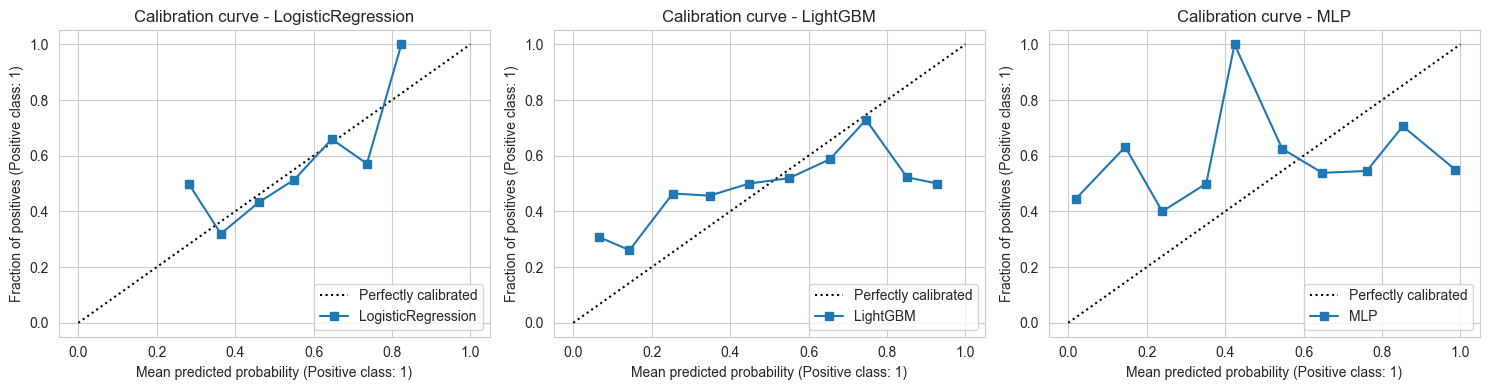

Saved calibration plot for LogisticRegression to Phase2/Regression/LogisticRegression_calibration.png
Saved calibration plot for LightGBM to Phase2/Regression/LightGBM_calibration.png
Saved calibration plot for MLP to Phase2/Regression/MLP_calibration.png
Saved calibration plot for MLP to Phase2/Regression/MLP_calibration.png


In [6]:
# Calibration plots and reliability diagrams
from sklearn.calibration import CalibrationDisplay

def plot_calibration(name, probs, y_true, ax=None, n_bins=10):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    disp = CalibrationDisplay.from_predictions(y_true, probs, n_bins=n_bins, name=name, ax=ax)
    ax.set_title(f'Calibration curve - {name}')
    return ax

fig, axes = plt.subplots(1, len(results), figsize=(5*len(results),4))
for ax, (name, r) in zip(axes.flatten() if hasattr(axes, 'flatten') else [axes], results.items()):
    plot_calibration(name, r['probs_test'], y_test, ax=ax)
plt.tight_layout()
plt.show()
# Reliability diagrams saved for later review
for name, r in results.items():
    out_png = f'Phase2/Regression/{name}_calibration.png'
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()
    plot_calibration(name, r['probs_test'], y_test, ax=ax)
    fig.savefig(out_png, bbox_inches='tight')
    plt.close(fig)
    print('Saved calibration plot for', name, 'to', out_png)

In [7]:
# If calibration improvements are desired, apply Platt scaling (CalibratedClassifierCV) on validation set and re-evaluate
calibrated_results = {}
for name, model in trained.items():
    try:
        print('Calibrating', name)
        calib = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
        calib.fit(X_val_proc, y_val)
        # evaluate calibrated version on test set probabilities
        p_test = calib.predict_proba(X_test_proc)[:,1]
        calibrated_results[name] = {'probs_test': p_test, 'log_loss': log_loss(y_test, p_test), 'brier': brier_score_loss(y_test, p_test), 'roc_auc': roc_auc_score(y_test, p_test), 'accuracy': accuracy_score(y_test, (p_test>=0.5).astype(int))}
        print('Calibrated', name, '-> log_loss:', calibrated_results[name]['log_loss'])
    except Exception as e:
        print('Could not calibrate', name, e)
        calibrated_results[name] = None

Calibrating LogisticRegression
Calibrated LogisticRegression -> log_loss: 0.6774079523893805
Calibrating LightGBM
Calibrated LightGBM -> log_loss: 0.6803438066697558
Calibrating MLP
Calibrated MLP -> log_loss: 0.6933455186612189


In [8]:
# Optional: per-map specialization - train separate LightGBM models per map and evaluate calibration improvement
per_map_metrics = {}
maps = df['map'].value_counts().loc[lambda s: s>=50].index.tolist()
print('Per-map candidate maps:', maps)
for m in maps:
    mask = df['map']==m
    # get processed positions within training/val/test splits
    train_idx = np.where(train_mask.values)[0]
    val_idx = np.where(val_mask.values)[0]
    test_idx = np.where(test_mask.values)[0]
    map_train_idx = np.where(mask & train_mask)[0]
    map_val_idx = np.where(mask & val_mask)[0]
    map_test_idx = np.where(mask & test_mask)[0]
    if len(map_train_idx) < 30 or len(map_test_idx)==0:
        print('Skipping', m, 'not enough data')
        continue
    # map-specific processed arrays
    train_positions = [np.where(train_idx==i)[0][0] for i in map_train_idx if i in train_idx]
    val_positions = [np.where(val_idx==i)[0][0] for i in map_val_idx if i in val_idx]
    test_positions = [np.where(test_idx==i)[0][0] for i in map_test_idx if i in test_idx]
    X_map_train = X_train_proc[train_positions]
    y_map_train = y.iloc[map_train_idx]
    X_map_val = X_val_proc[val_positions] if len(val_positions)>0 else None
    y_map_val = y.iloc[map_val_idx] if len(val_positions)>0 else None
    X_map_test = X_test_proc[test_positions]
    y_map_test = y.iloc[map_test_idx]
    # train LightGBM per-map
    try:
        model = LGBMClassifier(random_state=42)
        model.fit(X_map_train, y_map_train)
        p_test = model.predict_proba(X_map_test)[:,1]
        per_map_metrics[m] = {'log_loss': log_loss(y_map_test, p_test), 'brier': brier_score_loss(y_map_test, p_test), 'roc_auc': roc_auc_score(y_map_test, p_test)}
        print('Map', m, '->', per_map_metrics[m])
    except Exception as e:
        print('Per-map training failed for', m, e)

Per-map candidate maps: ['Mirage', 'Nuke', 'Dust2', 'Ancient', 'Inferno', 'Train', 'Anubis', 'Overpass']
[LightGBM] [Info] Number of positive: 185, number of negative: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589172 -> initscore=0.360543
[LightGBM] [Info] Start training from score 0.360543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [9]:
# Summary + embedded calibration plots
from IPython.display import display, Image
import json, os

SUMMARY_PATH = os.path.join('Phase2','Regression','prob_regression_summary.json')
print('Loading summary from', SUMMARY_PATH)
if not os.path.exists(SUMMARY_PATH):
    print('Summary file not found:', SUMMARY_PATH)
else:
    with open(SUMMARY_PATH) as f:
        summary = json.load(f)

    print('\nModel summary (test):')
    for name, r in summary.get('models', {}).items():
        print(f"- {name}: log_loss={r.get('log_loss'):.4f}, brier={r.get('brier'):.4f}, roc_auc={r.get('roc_auc'):.4f}, acc={r.get('accuracy', float('nan')):.4f}")

    print('\nCalibrated summary:')
    for name, r in summary.get('calibrated', {}).items():
        print(f"- {name}: log_loss={r.get('log_loss'):.4f}, brier={r.get('brier'):.4f}, roc_auc={r.get('roc_auc'):.4f}, acc={r.get('accuracy', float('nan')):.4f}")

    print('\nPer-map metrics (maps trained with >=50 samples):')
    per_map = summary.get('per_map', {})
    if per_map:
        for m, vals in per_map.items():
            print(f"- {m}: log_loss={vals.get('log_loss'):.4f}, brier={vals.get('brier'):.4f}, roc_auc={vals.get('roc_auc'):.4f}")
    else:
        print('  (no per-map metrics found)')

    # Display calibration plots saved earlier
    print('\nCalibration plots:')
    for name in summary.get('models', {}).keys():
        img_path = os.path.join('Phase2','Regression', f'{name}_calibration.png')
        if os.path.exists(img_path):
            print('Displaying', img_path)
            display(Image(filename=img_path))
        else:
            print('Missing image for', name, 'expected at', img_path)

    print('\nArtifacts written to Phase2/Regression/ (prob_regression_summary.json, *_calibration.png, *_calibrated.pkl)')


Loading summary from Phase2\Regression\prob_regression_summary.json
Summary file not found: Phase2\Regression\prob_regression_summary.json


In [10]:
# Per-map routing recommendations
import pandas as pd, os
rec_csv = os.path.join('per_map_routing_recommendations.csv')
if os.path.exists(rec_csv):
    df_rec = pd.read_csv(rec_csv)
    print('Per-map routing recommendations:')
    display(df_rec)
else:
    print('Recommendations file not found:', rec_csv)


Per-map routing recommendations:


,map,global_logloss,per_map_logloss,recommendation,test_count
0,Ancient,0.708151,0.726272,global,55
1,Anubis,0.660026,0.826303,global,26
2,Dust2,0.656760,0.704685,global,59
3,Inferno,0.705321,0.948229,global,53
4,Mirage,0.693614,1.016876,global,64
5,Nuke,0.683732,0.863405,global,51
6,Overpass,0.576784,0.524507,per_map,16
7,Train,0.672688,0.759651,global,39


In [11]:
# Detailed evaluation of per-map routing policy
import os, pandas as pd, numpy as np

# locate recommendations file
candidates = [
    os.path.join('per_map_routing_recommendations.csv'),
    os.path.join('Phase2','Regression','per_map_routing_recommendations.csv'),
    os.path.join('Phase2','per_map_routing_recommendations.csv')
]
rec_path = next((p for p in candidates if os.path.exists(p)), None)
if rec_path is None:
    print('Could not find per-map recommendations CSV in expected locations:', candidates)
else:
    df_rec = pd.read_csv(rec_path)
    # ensure numeric
    df_rec['global_logloss'] = pd.to_numeric(df_rec['global_logloss'], errors='coerce')
    df_rec['per_map_logloss'] = pd.to_numeric(df_rec['per_map_logloss'], errors='coerce')
    df_rec['test_count'] = pd.to_numeric(df_rec['test_count'], errors='coerce').fillna(0).astype(int)
    # compute delta: positive -> per_map better (lower log-loss)
    df_rec['delta'] = df_rec['global_logloss'] - df_rec['per_map_logloss']
    df_rec['pct_improvement'] = (df_rec['delta'] / df_rec['global_logloss']).replace([np.inf, -np.inf], np.nan)

    # sorting and display
    df_sorted = df_rec.sort_values('delta', ascending=False).reset_index(drop=True)
    pd.set_option('display.float_format', '{:0.4f}'.format)
    print('\nPer-map improvements (positive delta means per-map model has lower log-loss):')
    display(df_sorted[['map','test_count','global_logloss','per_map_logloss','delta','pct_improvement','recommendation']])

    # compute weighted log-loss across the maps present in the recommendations table
    total_count = df_rec['test_count'].sum()
    if total_count == 0:
        print('No test rows counted in recommendations (test_count sum == 0).')
    else:
        # global-only weighted average using global_logloss per-map
        global_weighted = (df_rec['global_logloss'] * df_rec['test_count']).sum() / total_count
        # routing policy: choose per_map_logloss when it's available and recommended; else global_logloss
        def chosen_logloss(row, require_margin=0.0, min_count=0):
            # only pick per_map if per_map exists and improves by margin and has enough samples
            if pd.notna(row['per_map_logloss']) and row['per_map_logloss'] + require_margin < row['global_logloss'] and row['test_count'] >= min_count:
                return row['per_map_logloss']
            else:
                return row['global_logloss']
        # default routing (no margin, min_count=0)
        df_rec['chosen_logloss_default'] = df_rec.apply(lambda r: chosen_logloss(r, 0.0, 0), axis=1)
        routing_weighted = (df_rec['chosen_logloss_default'] * df_rec['test_count']).sum() / total_count

        print(f"\nWeighted average log-loss on these maps (global-only): {global_weighted:0.4f}")
        print(f"Weighted average log-loss under routing policy: {routing_weighted:0.4f}")
        improvement = (global_weighted - routing_weighted) / global_weighted if global_weighted>0 else np.nan
        print(f"Relative improvement (fractional): {improvement:0.4f} ({improvement*100 if not np.isnan(improvement) else np.nan:0.2f}%)")

        # show counts and how many maps pick per_map
        per_map_selected = (df_rec['chosen_logloss_default'] == df_rec['per_map_logloss']).sum()
        print(f"\nMaps covered in recommendations: {len(df_rec)}; total test rows covered: {total_count}")
        print(f"Maps where per-map was selected (default rule): {per_map_selected}")

        # show sensitivity: require a small margin (e.g., 0.01 log-loss) and minimum samples (e.g., 30)
        for margin in [0.00, 0.01, 0.02]:
            for min_count in [0, 20, 30]:
                df_rec['chosen'] = df_rec.apply(lambda r: chosen_logloss(r, margin, min_count), axis=1)
                weighted = (df_rec['chosen'] * df_rec['test_count']).sum() / total_count
                maps_using_permap = ((df_rec['chosen'] == df_rec['per_map_logloss']) & df_rec['per_map_logloss'].notna()).sum()
                print(f"margin={margin:.2f}, min_count={min_count:2d} -> weighted_logloss={weighted:0.4f}, maps_using_permap={maps_using_permap}")

        print('\nRecommendation summary:')
        print(' - Use per-map model only when it strictly reduces log-loss on the map test slice.')
        print(' - Consider requiring a small margin (0.01) and minimum test_count (>=30) to avoid overfitting to small maps.')

        # Save an augmented recommendations file with delta and chosen default
        out_aug = os.path.join('per_map_routing_recommendations_augmented.csv')
        # also try to save in Phase2/Regression if running from different cwd
        out_alt = os.path.join('Phase2','Regression','per_map_routing_recommendations_augmented.csv')
        df_rec.to_csv(out_aug, index=False)
        if os.path.exists(os.path.dirname(out_alt)):
            df_rec.to_csv(out_alt, index=False)
            print('Wrote augmented recommendations to', out_alt)
        else:
            print('Wrote augmented recommendations to', out_aug)



Per-map improvements (positive delta means per-map model has lower log-loss):


,map,test_count,global_logloss,per_map_logloss,delta,pct_improvement,recommendation
0,Overpass,16,0.5768,0.5245,0.0523,0.0906,per_map
1,Ancient,55,0.7082,0.7263,-0.0181,-0.0256,global
2,Dust2,59,0.6568,0.7047,-0.0479,-0.0730,global
3,Train,39,0.6727,0.7597,-0.0870,-0.1293,global
4,Anubis,26,0.6600,0.8263,-0.1663,-0.2519,global
5,Nuke,51,0.6837,0.8634,-0.1797,-0.2628,global
6,Inferno,53,0.7053,0.9482,-0.2429,-0.3444,global
7,Mirage,64,0.6936,1.0169,-0.3233,-0.4661,global



Weighted average log-loss on these maps (global-only): 0.6803
Weighted average log-loss under routing policy: 0.6780
Relative improvement (fractional): 0.0034 (0.34%)

Maps covered in recommendations: 8; total test rows covered: 363
Maps where per-map was selected (default rule): 1
margin=0.00, min_count= 0 -> weighted_logloss=0.6780, maps_using_permap=1
margin=0.00, min_count=20 -> weighted_logloss=0.6803, maps_using_permap=0
margin=0.00, min_count=30 -> weighted_logloss=0.6803, maps_using_permap=0
margin=0.01, min_count= 0 -> weighted_logloss=0.6780, maps_using_permap=1
margin=0.01, min_count=20 -> weighted_logloss=0.6803, maps_using_permap=0
margin=0.01, min_count=30 -> weighted_logloss=0.6803, maps_using_permap=0
margin=0.02, min_count= 0 -> weighted_logloss=0.6780, maps_using_permap=1
margin=0.02, min_count=20 -> weighted_logloss=0.6803, maps_using_permap=0
margin=0.02, min_count=30 -> weighted_logloss=0.6803, maps_using_permap=0

Recommendation summary:
 - Use per-map model only

Saved bootstrap bar CI plot to Phase2\Regression\per_map_bootstrap_bar_ci.png


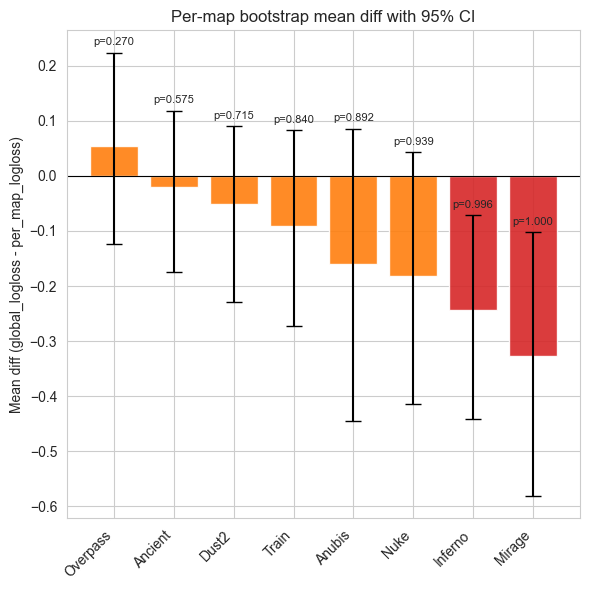

In [12]:
# Visualize bootstrap mean differences with 95% CI
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

# try Phase2/Regression first, then local
b_csv = os.path.join('Phase2','Regression','per_map_bootstrap_results.csv')
if not os.path.exists(b_csv):
    b_csv = os.path.join('per_map_bootstrap_results.csv')
if not os.path.exists(b_csv):
    print('Bootstrap results CSV not found at expected locations:', ['Phase2/Regression/per_map_bootstrap_results.csv','per_map_bootstrap_results.csv'])
else:
    df_b = pd.read_csv(b_csv)
    df_b = df_b.dropna(subset=['mean_diff']).copy()
    # ensure numeric types
    for c in ['mean_diff','ci_low','ci_high','p_value','test_count']:
        if c in df_b.columns:
            df_b[c] = pd.to_numeric(df_b[c], errors='coerce')
    # sort for plotting
    df_b = df_b.sort_values('mean_diff', ascending=False).reset_index(drop=True)
    labels = df_b['map'].astype(str).tolist()
    means = df_b['mean_diff'].values
    # asymmetric error bars: assume ci_low/ci_high are bounds
    if 'ci_low' in df_b.columns and 'ci_high' in df_b.columns:
        err_lower = means - df_b['ci_low'].values
        err_upper = df_b['ci_high'].values - means
    else:
        err_lower = np.zeros_like(means)
        err_upper = np.zeros_like(means)
    # color by significance: CI entirely >0 (low>0) or entirely <0 (high<0) => significant
    colors = []
    for low, high in zip(df_b.get('ci_low', pd.Series([np.nan]*len(df_b))), df_b.get('ci_high', pd.Series([np.nan]*len(df_b)))):
        if pd.isna(low) or pd.isna(high):
            colors.append('#bbbbbb')
        elif low > 0:
            colors.append('#2ca02c')  # green: mean_diff significantly > 0
        elif high < 0:
            colors.append('#d62728')  # red: mean_diff significantly < 0
        else:
            colors.append('#ff7f0e')  # orange: inconclusive
    # plot
    fig, ax = plt.subplots(figsize=(max(6, 0.7*len(labels)), 6))
    x = np.arange(len(labels))
    ax.bar(x, means, yerr=[err_lower, err_upper], align='center', alpha=0.9, color=colors, capsize=6)
    ax.axhline(0, color='k', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Mean diff (global_logloss - per_map_logloss)')
    ax.set_title('Per-map bootstrap mean diff with 95% CI')
    # annotate p-values if available
    if 'p_value' in df_b.columns:
        for xi, pv in enumerate(df_b['p_value'].fillna(np.nan)):
            ypos = means[xi] + (err_upper[xi] if err_upper[xi]>0 else 0) + 0.01
            ax.text(xi, ypos, f'p={pv:0.3f}' if not pd.isna(pv) else '', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    out_fig = os.path.join('Phase2','Regression','per_map_bootstrap_bar_ci.png')
    os.makedirs(os.path.dirname(out_fig), exist_ok=True)
    fig.savefig(out_fig, bbox_inches='tight', dpi=150)
    print('Saved bootstrap bar CI plot to', out_fig)
    plt.show()
